## Load Packages

In [119]:
import os
from IPython.display import display

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import math
from dateutil import parser

from bertopic import BERTopic
import nltk
from nltk.corpus import stopwords

from wordcloud import WordCloud

from sklearn.feature_extraction.text import CountVectorizer

import umap # dimensionality reduction for text embedding
import hdbscan # Hierarchical Density-Based Spatial Clustering of Applications with Noise

## Load Data

In [4]:
base_dir = r"C:\Users\TYY\Desktop\MITB Modules\CS610 AML\Group Project\V2"
df_bert = pd.read_csv(f"{base_dir}/singapore_airlines_reviews.csv")

In [6]:
df_bert

,published_date,published_platform,rating,type,text,title,helpful_votes
0,2024-03-12T14:41:14-04:00,Desktop,3,review,We used this airline to go from Singapore to L...,Ok,0
1,2024-03-11T19:39:13-04:00,Desktop,5,review,The service on Singapore Airlines Suites Class...,The service in Suites Class makes one feel lik...,0
2,2024-03-11T12:20:23-04:00,Desktop,1,review,"Booked, paid and received email confirmation f...",Don’t give them your money,0
3,2024-03-11T07:12:27-04:00,Desktop,5,review,"Best airline in the world, seats, food, servic...",Best Airline in the World,0
4,2024-03-10T05:34:18-04:00,Desktop,2,review,Premium Economy Seating on Singapore Airlines ...,Premium Economy Seating on Singapore Airlines ...,0
...,...,...,...,...,...,...,...
9995,2018-08-06T03:48:21-04:00,Desktop,5,review,First part done with Singapore Airlines - acce...,"Flew to NZ 1st half Singapore Airlines, 2nd ha...",1
9996,2018-08-05T22:50:29-04:00,Mobile,5,review,And again a great Flight with Singapore Air. G...,Best Airline,1
9997,2018-08-05T22:47:06-04:00,Desktop,5,review,"We flew business class from Frankfurt, via Sin...",Superb service on Singapore Airlines,1
9998,2018-08-05T20:32:03-04:00,Desktop,4,review,"As always, the A380 aircraft was spotlessly pr...",A Comfortable Fiight Spoiled by lack of adequa...,2


## Text Processing

**Handling Long Documents**
- Based on previous EDA there are certain documents with extremely long text
- By default, the large documents will be truncated by BERTopic. That is how the underlying sentence-transformers model handles large documents. It all depends on the embedding model you choose. (https://github.com/MaartenGr/BERTopic/issues/491)
- Another suggestion of the founder of BERTopic is to split the long documents into sentences (https://github.com/MaartenGr/BERTopic/issues/540)

Overall tips: https://maartengr.github.io/BERTopic/getting_started/tips_and_tricks/tips_and_tricks.html

In [13]:
# Method 1: Chunk long reviews by paragraphs
def split_into_paragraphs(text, min_words=20, max_words=200):
    paragraphs = re.split(r'\n\s*\n', text) # Split on double newlines or newlines (as fallback)
    chunks = []
    for p in paragraphs:
        words = p.split() # split words in paragraph into list
        if min_words <= len(words) <= max_words: # keep paragraphs between 20-200 words
            chunks.append(p)
        elif len(words) > max_words:
            for i in range(0, len(words), max_words): # Further split long paragraphs
                chunk = ' '.join(words[i:i+max_words])
                if len(chunk.split()) >= min_words:
                    chunks.append(chunk)
    return chunks

# Each element will be the original paragraph that’s the right size OR
# longer paragraph, broken into a chunk that fits the word limits.

In [17]:
# Add a word_count column so that I can filter later
df_bert["word_count"] = df_bert["text"].astype(str).str.split().str.len() # split string into word arrays and count num words

In [19]:
# Filter reviews > 200 words
long_reviews = df_bert[df_bert["word_count"] > 200]

# Method 1: By paragraphs
long_reviews['chunks'] = long_reviews['text'].apply(split_into_paragraphs)

# Flatten to a DataFrame of chunks
chunked_rows = []
for idx, row in long_reviews.iterrows():
    for chunk in row['chunks']:
        chunked_rows.append({'text': chunk, 'orig_review_id': idx})  # Generate a idx, keep original, to aggregate back later

df_chunks = pd.DataFrame(chunked_rows)

In [23]:
# Inspected chunking results, look accurate for 1st 2 samples
df_chunks.head(10)

,text,orig_review_id
0,We used this airline to go from Singapore to L...,0
1,We got to the airport and had to check in at t...,0
2,"Overall the flight was ok, seats were comfy, l...",0
3,The service on Singapore Airlines Suites Class...,1
4,The Suites Class cabin resembles the private c...,1
5,Not all suites have the same size. The biggest...,1
6,The seat was the first thing that caught my ey...,1
7,There is no lack of storage space in the Suite...,1
8,"Respected Faculty, I am Bincy, writing this to...",8
9,arrange any room to rest or any proper lounge ...,8


In [27]:
# Combine back short reviews
df_bert_final = pd.concat([
    df_bert[(df_bert["word_count"] >= 20) & (df_bert["word_count"] <= 200)][['text']], # short reviews
    df_chunks[['text']] # long reviews chunked
], ignore_index=True)

In [29]:
# Prepare df_bert_final into list formated expected by BERTopic
docs_bert = df_bert_final["text"].tolist()

In [33]:
# Implement suggestions given by BERTopic founder 
# (https://maartengr.github.io/BERTopic/getting_started/tips_and_tricks/tips_and_tricks.html#removing-stop-words)
# Use countvectorizer to remove stop words
# Reduce impact of frequent words 

from sklearn.feature_extraction.text import CountVectorizer
from bertopic.vectorizers import ClassTfidfTransformer

vectorizer_model = CountVectorizer(stop_words="english")
ctfidf_model = ClassTfidfTransformer(reduce_frequent_words=True)

## Instantiate BERTopic Model (Default)

In [60]:
# Instantiate basic BERTopic Mode
topic_model_default = BERTopic(vectorizer_model=vectorizer_model, ctfidf_model=ctfidf_model)

In [62]:
# Fit (quite fast, < 1 min)
topics_default, probs_default = topic_model_default.fit_transform(docs_bert)

In [64]:
# Extract topics
# Reference: https://maartengr.github.io/BERTopic/getting_started/quickstart/quickstart.html#quick-start
pd.set_option('display.max_colwidth', None)  
topic_info_default = topic_model_default.get_topic_info()
print(topic_info_default)

# -1 outliers
# Result, 80-90 topics too much

    Topic  Count                                     Name  \
0      -1   6028       -1_aircraft_plane_helpful_boarding   
1       0    689          0_refund_cancelled_ticket_phone   
2       1    458                          1_sq_sqs_sin_cx   
3       2    412         2_brisbane_perth_sydney_canberra   
4       3    381               3_asia_world_best_reliable   
..    ...    ...                                      ...   
83     82     11  82_regimentation_plying_smirnoff_vodkas   
84     83     10       83_lights_bizarrely_tyo_discretely   
85     84     10       84_newark_nonstop_glide_summerthis   
86     85     10       85_needsthe_owls_threat_estimation   
87     86     10                86_vomit_stank_wet_stream   

                                                                                                 Representation  \
0                           [aircraft, plane, helpful, boarding, meals, attentive, room, leg, friendly, little]   
1                             [refund

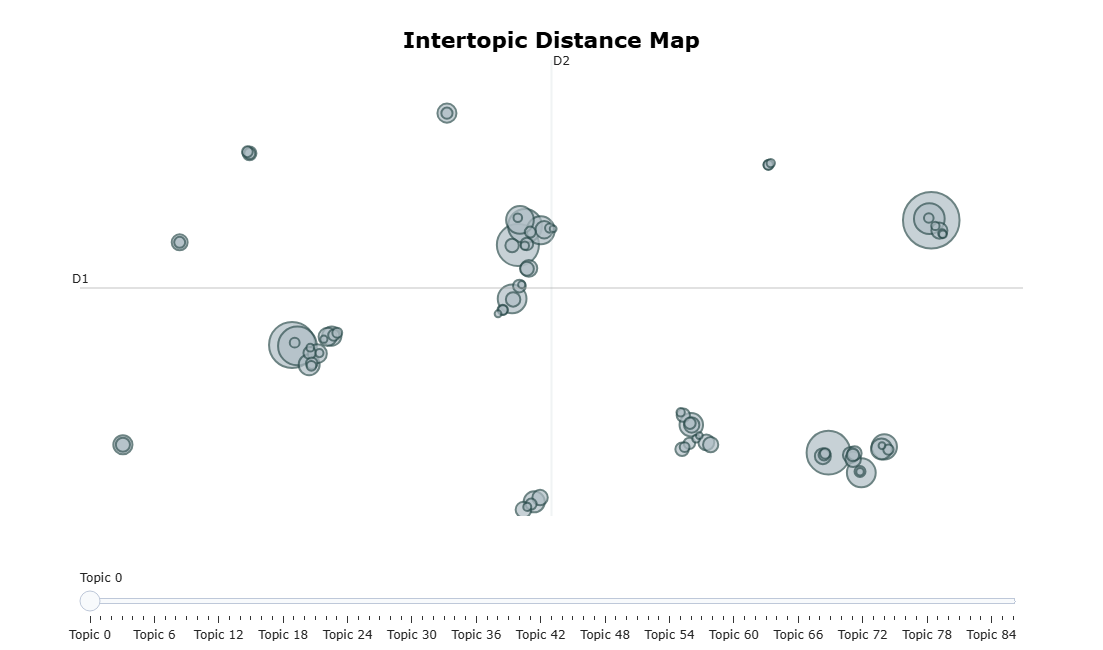

In [66]:
# Intertopic distance map
# 10 topics is ideal
topic_model_default.visualize_topics()

## Instantiate BERTopic Model (10 Topics)

In [68]:
# Set to 10 topics
topic_model = BERTopic(
    vectorizer_model=vectorizer_model,
    ctfidf_model=ctfidf_model,
    min_topic_size=10,
    nr_topics=10 
)

In [70]:
# Fit (quite fast, < 1 min)
topics, probs = topic_model.fit_transform(docs_bert)

In [72]:
# Extract topics
# Reference: https://maartengr.github.io/BERTopic/getting_started/quickstart/quickstart.html#quick-start
pd.set_option('display.max_colwidth', None)  
topic_info = topic_model.get_topic_info()
print(topic_info)

# -1 outliers

   Topic  Count                                Name  \
0     -1   5948       -1_flight_food_singapore_good   
1      0   4385     0_singapore_service_sq_airlines   
2      1    950    1_refund_ticket_customer_luggage   
3      2    315          2_meal_served_water_gluten   
4      3    215      3_bassinet_check_seat_boarding   
5      4    174            4_seat_bed_mode_position   
6      5    165       5_premium_economy_worth_extra   
7      6     60     6_ife_controller_tv_touchscreen   
8      7     54     7_toilet_toilets_seatbelt_paper   
9      8     15  8_cold_temperature_freezing_stuffy   

                                                                               Representation  \
0                [flight, food, singapore, good, seats, service, airlines, seat, staff, time]   
1             [singapore, service, sq, airlines, good, food, great, flight, airline, economy]   
2         [refund, ticket, customer, luggage, phone, told, change, email, booking, cancelled]   
3     

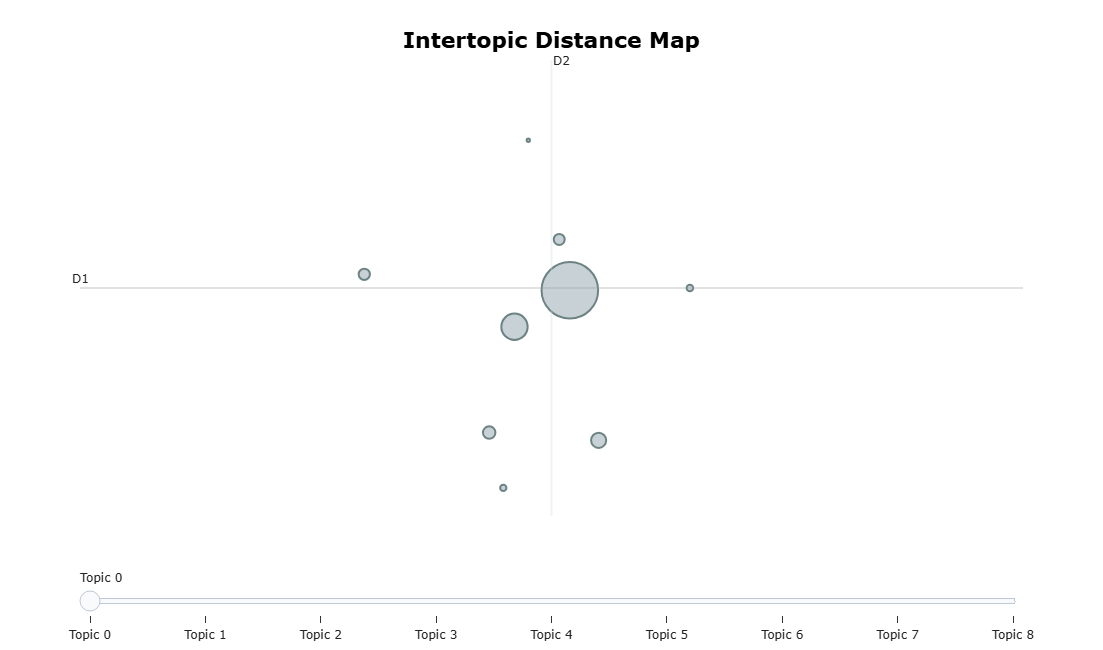

In [74]:
# Intertopic distance map
topic_model.visualize_topics()

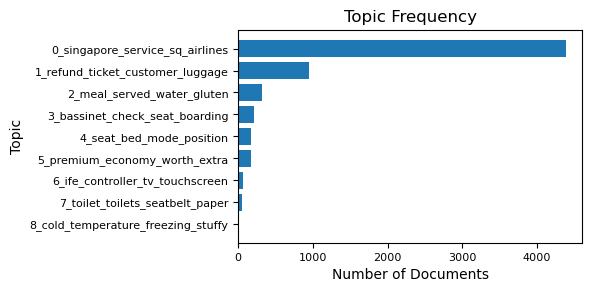

In [108]:
# Plot topic information
topic_info = topic_model.get_topic_info()
filtered   = topic_info[topic_info.Topic != -1].sort_values("Count", ascending=True)

labels = filtered["Name"]
counts = filtered["Count"]

plt.figure(figsize=(6, 3))            
plt.barh(labels, counts)
plt.xlabel("Number of Documents", fontsize=10)
plt.ylabel("Topic", fontsize=10)
plt.title("Topic Frequency", fontsize=12)


plt.yticks(fontsize=8)
plt.xticks(fontsize=8)
plt.tight_layout(pad=1.0)
plt.show()

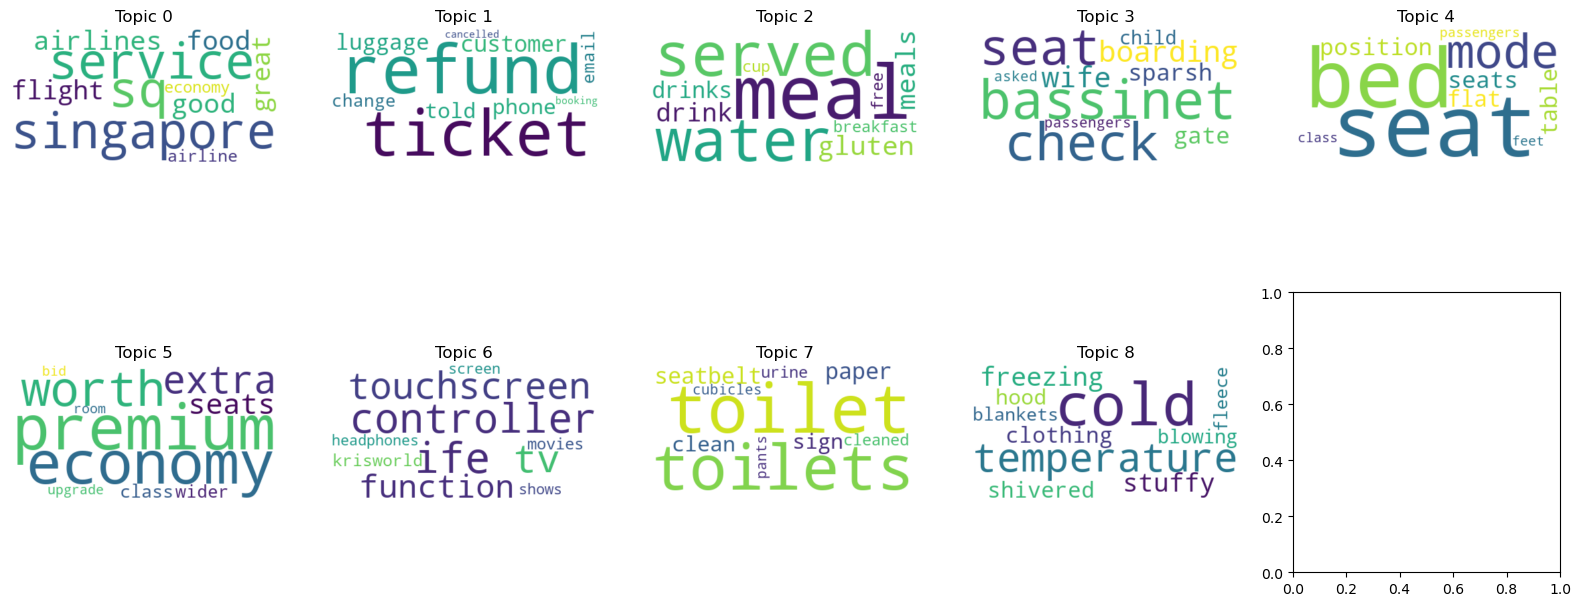

In [100]:
# Generate word cloud
# Reference: https://maartengr.github.io/BERTopic/getting_started/tips_and_tricks/tips_and_tricks.html#wordcloud
unique_topics = [t for t in topic_model.get_topics().keys() if t != -1][:10]
fig, axes = plt.subplots(2, 5, figsize=(20, 8))

def create_wordcloud(topic_model, topic):
    # Example: Get top words for topic
    words = dict(topic_model.get_topic(topic))
    wc = WordCloud(width=400, height=200, background_color="white").generate_from_frequencies(words)
    return wc

for i, topic_num in enumerate(unique_topics):
    ax = axes[i // 5, i % 5]
    wc = create_wordcloud(topic_model, topic=topic_num)
    ax.imshow(wc, interpolation="bilinear")
    ax.axis("off")
    ax.set_title(f"Topic {topic_num}")

#### Optional Investigation Stuff

In [ ]:
# Inspect topics at document level (optional)
topic_model.get_document_info(docs_bert)

In [54]:
# This returns a list of the top 5 docs that were assigned to topic -1 (outliers)
example_docs = topic_model.get_representative_docs(topic=-1)[:5]

for i, doc in enumerate(example_docs, 1):
    print(f"Example {i}:\n{doc}\n{'-'*80}")

Example 1:
We flew business class on the way out to Sydney which was ok, but coming back due to the fact we had to forfeit our Business return ...( yes no refund ) even when we asked and wanted to change our return flight six months prior to the booking date. So we had to buy brand new Premium economy tickets. Yes you get a bit more space but the service is pretty bad, the food is awful, chicken , or chicken or chicken every meal, unless you like asian food, we were serve the same cheese from Auckland to Singapore , Singapore to Zurich, on 3 occasions, serve a roll with nothing to put into it. No dessert or fruit to speak of just some kind of gelatinous bobble. I have travelled on Singapore Airlines several times incl pre Covid and it certainly has gone down. No offer of coffee or tea after the meal only with the meal. No second serving of a drink with the meal. The staff seem to do nothing ! you just see them at meal time and then they disappear. HOWEVER the main thing I guess is the 

## Topic Quality Evaluation

Evaluation method:  
https://github.com/MaartenGr/BERTopic/issues/90

In [80]:
os.environ["TOKENIZERS_PARALLELISM"] = "false"
import gensim.corpora as corpora # gensim library's corpora, which is used to create the dictionary and document-term matrix (DTM) for Gensim models
from gensim.models.coherencemodel import CoherenceModel # for evaluating quality of topics
from itertools import chain # chaining iterables together, flattening into a single list.

In [82]:
# Aggregate documents by topic
documents = pd.DataFrame({
    "Document": docs_bert,
    "Topic": topics
})
# Group docs by topic 
docs_per_topic = (documents.groupby("Topic", as_index=False).agg({"Document": " ".join}))

In [84]:
from gensim import corpora
from gensim.models import CoherenceModel
from itertools import chain

# top representative docs per topic (provided by BERT automatically)
rep_docs = topic_model.get_representative_docs()

# Preprocess and keep one doc per real topic
cleaned_docs = []
numeric_topics = []
for topic, docs in rep_docs.items():
    if topic == -1:
        continue
    # take the very first representative doc
    cleaned = topic_model._preprocess_text([docs[0]])[0] # Clean using BERTopic's internal text preprocessor
    cleaned_docs.append(cleaned)
    numeric_topics.append(topic)

analyzer = topic_model.vectorizer_model.build_analyzer()

# Tokenize each cleaned doc
tokens = [analyzer(doc) for doc in cleaned_docs]

# Build Gensim dict & BOW
dictionary = corpora.Dictionary(tokens)
bow_corpus = [dictionary.doc2bow(t) for t in tokens]

# top N words per topic from BERTopic model
# These will be evaluated for how well they "go together" semantically
N = 10
topic_words = [
    [w for w, _ in topic_model.get_topic(t)[:N]] 
    for t in numeric_topics
]

# Compute c_v coherence
coherence_model = CoherenceModel(
    topics=topic_words,
    texts=tokens,
    corpus=bow_corpus,
    dictionary=dictionary,
    coherence='c_v'
)
coherence_score = coherence_model.get_coherence()
print(f"Overall c_v coherence: {coherence_score:.4f}")

# Compute topic diversity
all_top_terms = list(chain.from_iterable(topic_words))
unique_terms  = set(all_top_terms)
diversity = len(unique_terms) / (N * len(topic_words))
print(
    f"Topic diversity (top {N} terms): {diversity:.4f} "
    f"({len(unique_terms)} unique of {N * len(topic_words)})"
)

# Higher score (closer to 1) = more coherent topics
# Measures how distinct the top words across different topics are.
# A diversity of 1.0 = all topics have completely different top words.
# Lower values = topics might be overlapping in vocabulary.

Overall c_v coherence: 0.6987
Topic diversity (top 10 terms): 0.9444 (85 unique of 90)


## Export Outputs of Topics

In [147]:
#Save the outputs for each topic
topics_output, probs_output = topic_model.transform(docs_bert) # Assigns each document a topic and a topic probability distribution

In [159]:
# Contains each document’s text, its assigned topic, and the highest topic probability.
doc_info = pd.DataFrame({
  "text":         docs_bert,
  "Topic":       topics_output,
  "Probability": [p.max() for p in probs_output]
})

# Get readable topic names
topic_meta_output = (
  topic_model
    .get_topic_info()
    .set_index("Topic")["Name"]
    .to_dict()
)

# Create an output folder, output each topic into a csv file
os.makedirs("by_topic", exist_ok=True)
for topic_id, group in doc_info.groupby("Topic"):
    name      = topic_meta_output.get(topic_id, str(topic_id))
    safe_name = f"topic{topic_id}_{name}".replace(" ", "_").replace("/", "_")
    path      = f"by_topic/{safe_name}.csv"
    group[["text"]].to_csv(path, index=False)
    print(f"Wrote {len(group)} docs for topic {topic_id}")

Wrote 5948 docs for topic -1
Wrote 4385 docs for topic 0
Wrote 950 docs for topic 1
Wrote 315 docs for topic 2
Wrote 215 docs for topic 3
Wrote 174 docs for topic 4
Wrote 165 docs for topic 5
Wrote 60 docs for topic 6
Wrote 54 docs for topic 7
Wrote 15 docs for topic 8


## Data Visualisations

Visualise Terms per Topic

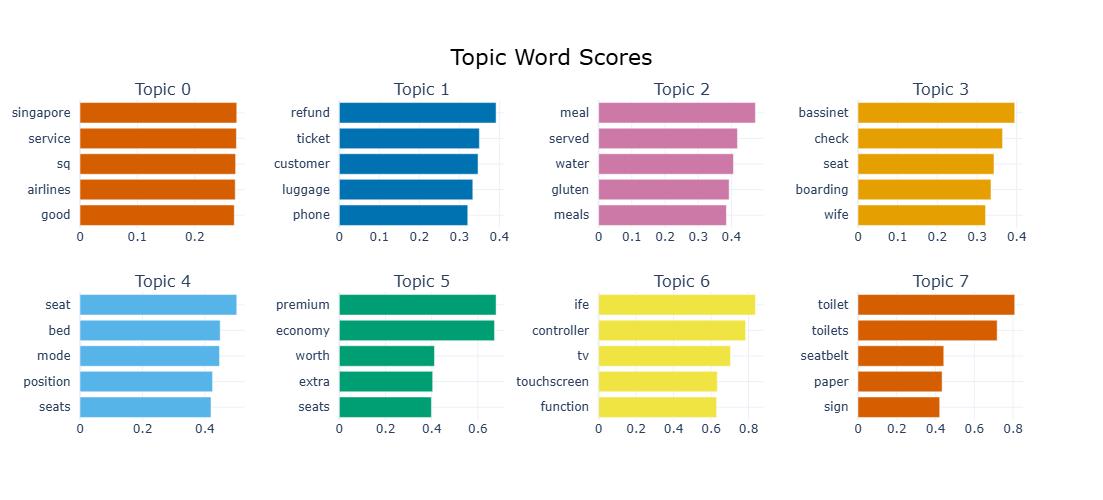

In [169]:
topic_model.visualize_barchart()

Topic Similarity

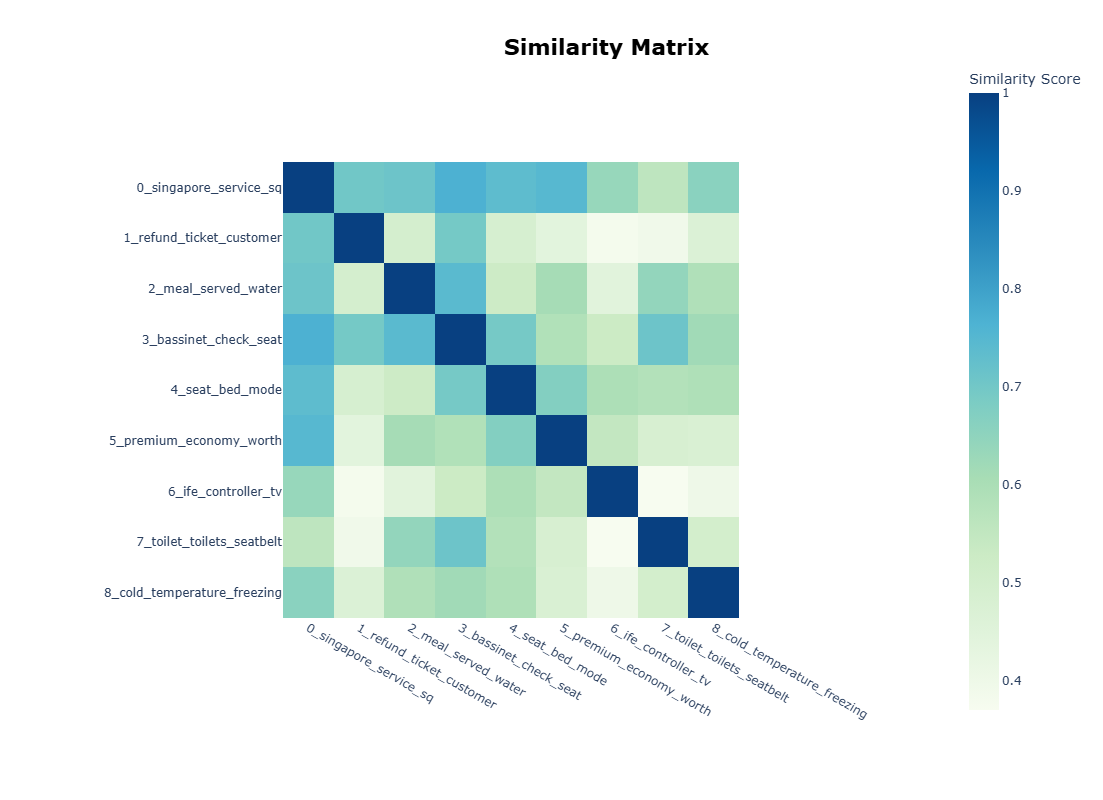

In [172]:
topic_model.visualize_heatmap()

Bert Topics Over Time

In [258]:
# Reload dataset again (previously set used for training no timestamp)
base_dir = r"C:\Users\TYY\Desktop\MITB Modules\CS610 AML\Group Project\V2"
df1 = pd.read_csv(f"{base_dir}/singapore_airlines_reviews.csv")

# Convert published_date to correct format
df1["published_date"] = pd.to_datetime(df1["published_date"], utc=True)

**Added a review_id based on the index**   
Why: So that when i split long text into chunks I can reassemble the chunks back to form the original review

In [260]:
df1 = df1.reset_index().rename(columns={'index': 'review_id'})

In [262]:
# Same text processing

# Add a word_count column so that I can filter later
df1["word_count"] = df1["text"].astype(str).str.split().str.len() # split string into word arrays and count num words

In [264]:
# Filter reviews > 200 words
df1_long_reviews = df1[df1["word_count"] > 200]

# Method 1: By paragraphs
df1_long_reviews['chunks'] = df1_long_reviews['text'].apply(split_into_paragraphs)

In [266]:
# Flatten to a DataFrame of chunks
df1_chunked_rows = []
for _, row in df1_long_reviews.iterrows():
    for chunk in row['chunks']:
        df1_chunked_rows.append({'review_id': row['review_id'], 'published_date': row['published_date'], 'text': chunk})
df1_chunks = pd.DataFrame(df1_chunked_rows)

In [268]:
df1_chunks.head()

,review_id,published_date,text
0,0,2024-03-12 18:41:14+00:00,We used this airline to go from Singapore to London Heathrow. We had issues with tickets as they cancelled one of the tickets and trying to get it sorted cost a lot of money due to roaming charges for the lengthy phone calls which were needed to get the ticket reinstated and them trying to charge varying amounts to resolve it. This was a very poor service.
1,0,2024-03-12 18:41:14+00:00,"We got to the airport and had to check in at the desk due to this issue which meant online check in couldn't be done. We were in premium economy which was spacious, two seats on either side of the plane and 3 seats in the middle. The plane seemed relatively new but not brand new. Legroom was good, seats were wider and had bigger arm rest in between the two seats which had the fold away tray tables in. There was a good choice of movies and other things such as TV shows, games etc. The food was ok, didn't seem to be much different from economy standard. The flight crew seemed friendly enough. They didn't really go up and down the isles with drinks only maybe twice for the whole 13-14 hour flight, which on other airlines they would have done it quite often."
2,0,2024-03-12 18:41:14+00:00,"Overall the flight was ok, seats were comfy, legroom good. Food was ok. The flight crew could have been more attentive especially with it being premium economy, you would expect the service to be slightly better than economy."
3,1,2024-03-11 23:39:13+00:00,"The service on Singapore Airlines Suites Class was nothing but excellent. The cabin crew was warm and friendly and, most importantly, came across as sincere and genuine. Throughout the flight, I interacted with Leading Stewardess Sharifah the most, who went all the way out to ensure we were comfortable and well taken care of. I saw her patrolling the cabin consistently to check if we needed anything(I could see her looking into the Suite), and she was always read y to assist us. She even offered to make up our bed after the breakfast run so that we could rest. When I asked if I could walk around both decks of the aircraft, Sharifah volunteered to show me around. She was very knowledgeable about the configurations in the A380 aircraft and even pointed to the best seats in each cabin class as we walked through."
4,1,2024-03-11 23:39:13+00:00,"The Suites Class cabin resembles the private cabins onboard sleeper trains, which gives Suites Class passengers some form of privacy. The cut holes on the cabin doors, in the shape of a flower design, somewhat reduce the privacy we got in the Suites Class cabins. There are two lavatories at the front of the aircraft catering to the six Suites Class passengers. The lavatory on the right is the bigger of the two, featuring a vanity table between the toilet and the sink. There is plenty of space in this lavatory for passengers to change into the Lalique pyjamas provided to Suites Class passengers. The lavatory on the left was smaller but no less luxurious. Passengers using this lavatory can still find it spacious to change in and out of their pyjamas. This lavatory still provides the same amenities as the larger lavatory."


In [270]:
df1_chunks.columns

Index(['review_id', 'published_date', 'text'], dtype='object')

In [272]:
df1_short_reviews = df1[(df1["word_count"] >= 20) & (df1["word_count"] <= 200)][['review_id', 'published_date', 'text']]

In [274]:
df1_short_reviews.head()

,review_id,published_date,text
2,2,2024-03-11 16:20:23+00:00,"Booked, paid and received email confirmation for extra legroom seats 10 Dec. 4 Feb checked and seas were gone. They resold our paid for seats and put us in standard seats. I have a spine support device that means I require the extra space. Couldn’t use it and had a 13 1/2 hour flight. I exited in a wheelchair unable to walk for my three week holiday. Tried 37 times to reach them, Philippines call centre is appalling."
3,3,2024-03-11 11:12:27+00:00,"Best airline in the world, seats, food, service are all brilliant. The crew are friendly and welcoming. We love flying with Singapore Airlines"
4,4,2024-03-10 09:34:18+00:00,"Premium Economy Seating on Singapore Airlines has narrow seats and poor leg room compared to Air NZ or Virgin. Drinks served in plastic beakers, roast chicken tough as was the meat in the noodle dinner. Orange juice concoction was not a premium offering. Toilets - we had to walk half way back down the Economy cabin to queue for the toilet. One toilet on the plane was not working. Having flown with Air NZ the day before the difference in amenities and poor value for money was apparent with Singapore Airlines. Poor Kris Flyer website if you wish to upgrade it doesn't work!"
5,5,2024-03-10 06:16:48+00:00,"We booked our flights a full 9 months in advance and paid well over $11,000 for a trip in 2 weeks time. we then booked our trip around the flights. Over the past 2 months they changed our flights over 6 times resulting in over 15 hours of stop overs and delays, making the trip almost 32 hours long.\nWe booked through flight centre and paid the extra to be able to cancel the flights.\nNow we're having to fight tooth and nail just to get a response let alone our money back. \nWe're now at the unenvious point of paying for litigation to reclaim our funds that they have had for 9 months to use as they wish.\nI have flown well over 30 times with this airline and our business and family hundreds of times but this is the end of our relationship and we will never fly or recommend them again.\nSuch poor integrity."
6,6,2024-03-10 05:54:43+00:00,"This was a fascinating experience. As I sat into my seat, the stewardess offered me a warm towel and I felt very very welcomed. They treat you too well haha. The seats were comfortable. They even gave me a teddy bear haha idk why."


In [276]:
# Combine back short reviews
df1_final = pd.concat([df1_short_reviews, df1_chunks], ignore_index=True)

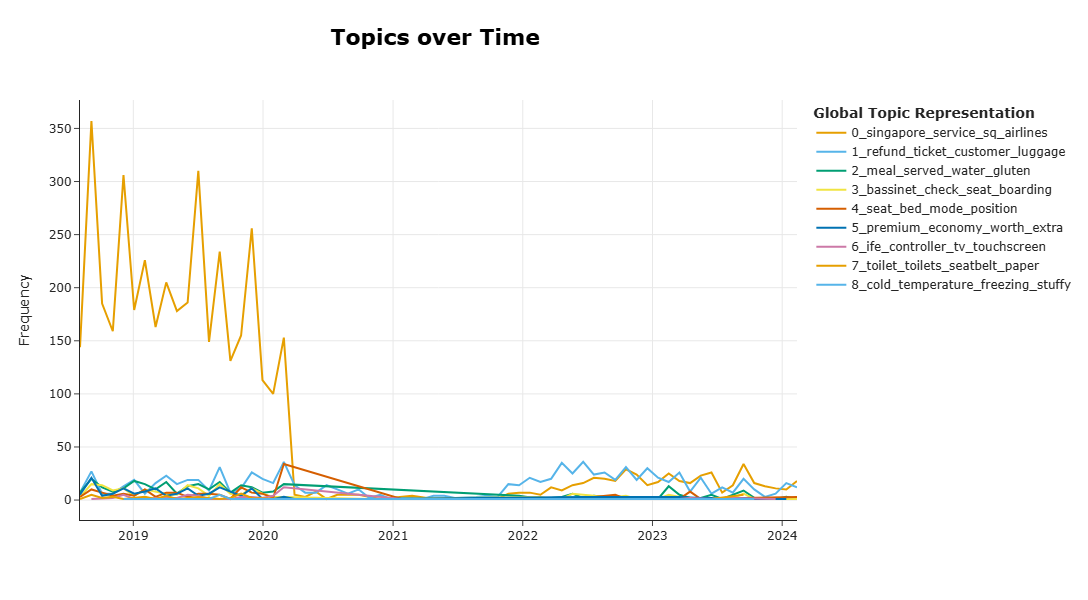

In [280]:
# Convert published_date into a proper datetime Series
df1_final["date"] = pd.to_datetime(df1_final["published_date"], utc=True)

# Prepare inputs
df1_docs       = df1_final["text"].astype(str).tolist()
df1_timestamps = df1_final["date"].tolist()

# assigns topics based on the existing topics learned from trained BERTopic model
topics_df1, probs_df1 = topic_model.transform(df1_docs)

# Compute the number of unique months for binning
df1_nr_bins = df1_final["date"].dt.to_period("M").nunique()

# Build topics-over-time DataFrame
df1_topics_over_time = topic_model.topics_over_time(
    docs=df1_docs,
    topics=topics_df1,
    timestamps=df1_timestamps,
    nr_bins=df1_nr_bins
)

# Visualize
fig = topic_model.visualize_topics_over_time(
    df1_topics_over_time,
    top_n_topics=10,
    height=600,
    width=1000
)
fig.show()

Visualise topics 1 by 1 (less clutter)

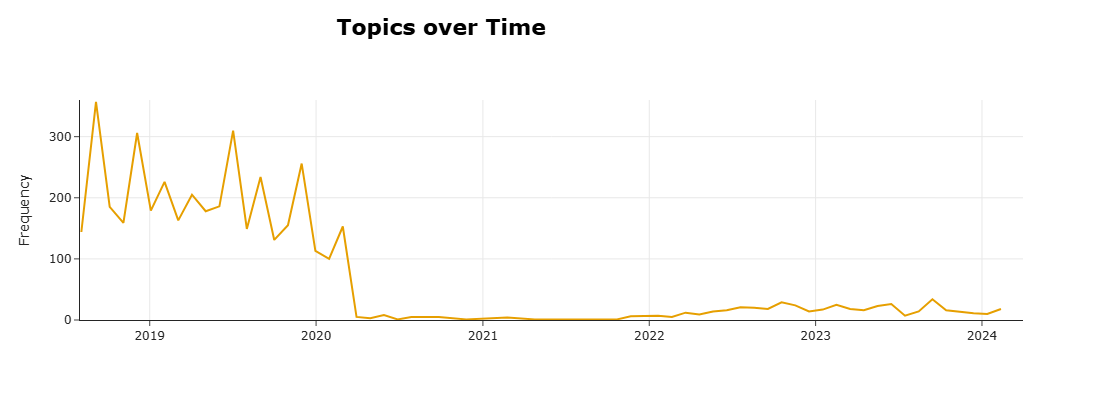

In [282]:
fig = topic_model.visualize_topics_over_time(
    df1_topics_over_time,
    topics=[0],
    height=400,
    width=600
)
fig.update_yaxes(range=[0, 360]) 
fig.update_xaxes(range=["2018-08-01", "2024-03-31"])
fig.show()

# topic_model.visualize_topics_over_time(df1_topics_over_time, topics=[0], height=400, width=600)

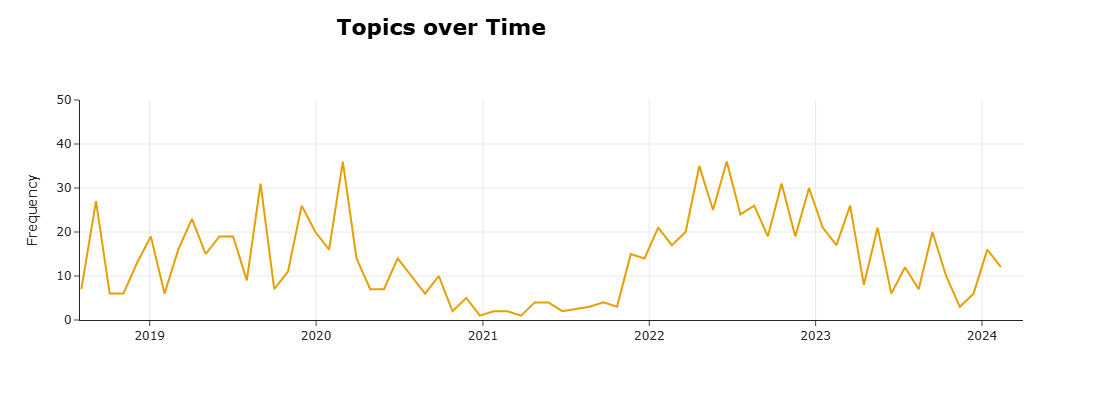

In [286]:
fig = topic_model.visualize_topics_over_time(
    df1_topics_over_time,
    topics=[1],
    height=400,
    width=600
)
fig.update_yaxes(range=[0, 50])  
fig.update_xaxes(range=["2018-08-01", "2024-03-31"])
fig.show()

# topic_model.visualize_topics_over_time(df1_topics_over_time, topics=[1], height=400, width=600)

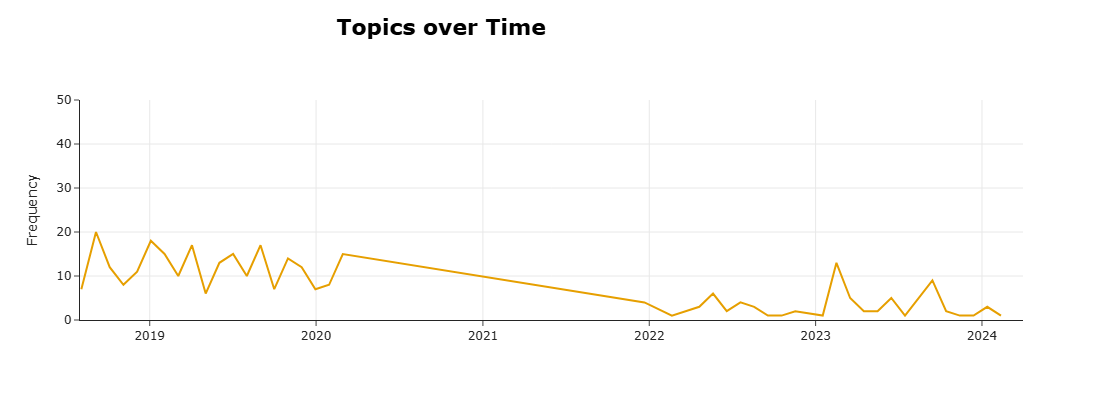

In [288]:
fig = topic_model.visualize_topics_over_time(
    df1_topics_over_time,
    topics=[2],
    height=400,
    width=600
)
fig.update_yaxes(range=[0, 50])  
fig.update_xaxes(range=["2018-08-01", "2024-03-31"])
fig.show()

# topic_model.visualize_topics_over_time(df1_topics_over_time, topics=[2], height=400, width=600)

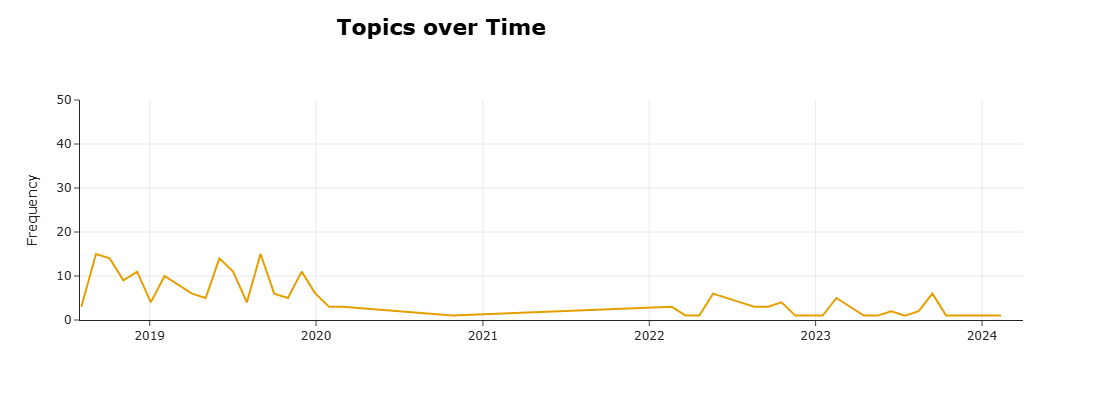

In [290]:
fig = topic_model.visualize_topics_over_time(
    df1_topics_over_time,
    topics=[3],
    height=400,
    width=600
)
fig.update_yaxes(range=[0, 50])  
fig.update_xaxes(range=["2018-08-01", "2024-03-31"])
fig.show()

# topic_model.visualize_topics_over_time(df1_topics_over_time, topics=[3], height=400, width=600)

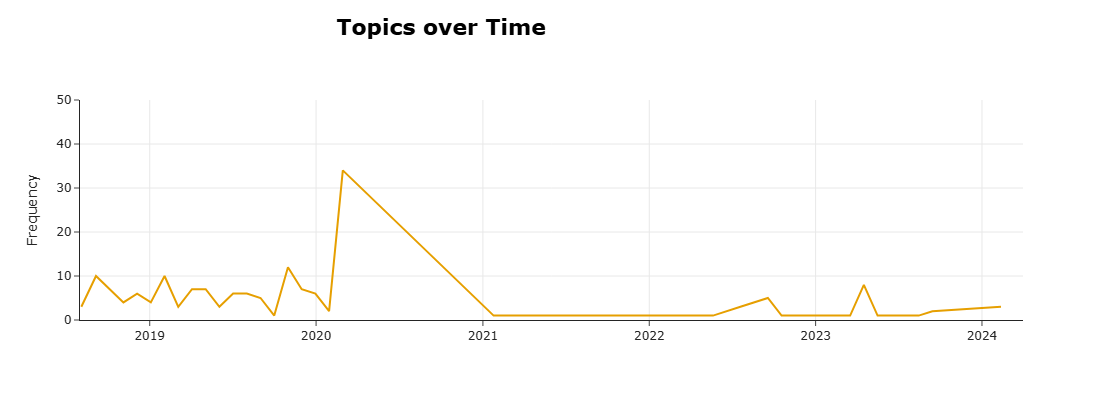

In [292]:
fig = topic_model.visualize_topics_over_time(
    df1_topics_over_time,
    topics=[4],
    height=400,
    width=600
)
fig.update_yaxes(range=[0, 50])  
fig.update_xaxes(range=["2018-08-01", "2024-03-31"])
fig.show()

# topic_model.visualize_topics_over_time(df1_topics_over_time, topics=[4], height=400, width=600)

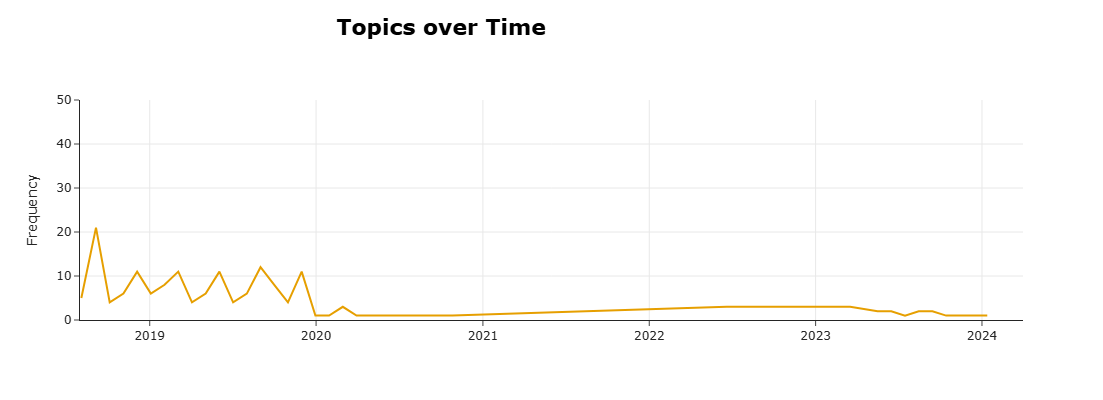

In [294]:
fig = topic_model.visualize_topics_over_time(
    df1_topics_over_time,
    topics=[5],
    height=400,
    width=600
)
fig.update_yaxes(range=[0, 50])  
fig.update_xaxes(range=["2018-08-01", "2024-03-31"])
fig.show()

# topic_model.visualize_topics_over_time(df1_topics_over_time, topics=[5], height=400, width=600)

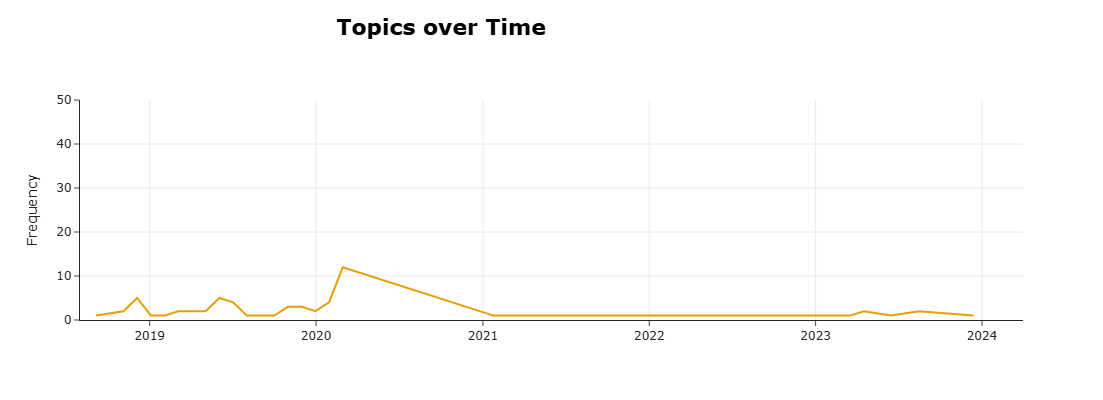

In [296]:
fig = topic_model.visualize_topics_over_time(
    df1_topics_over_time,
    topics=[6],
    height=400,
    width=600
)
fig.update_yaxes(range=[0, 50])  
fig.update_xaxes(range=["2018-08-01", "2024-03-31"])
fig.show()

# topic_model.visualize_topics_over_time(df1_topics_over_time, topics=[6], height=400, width=600)

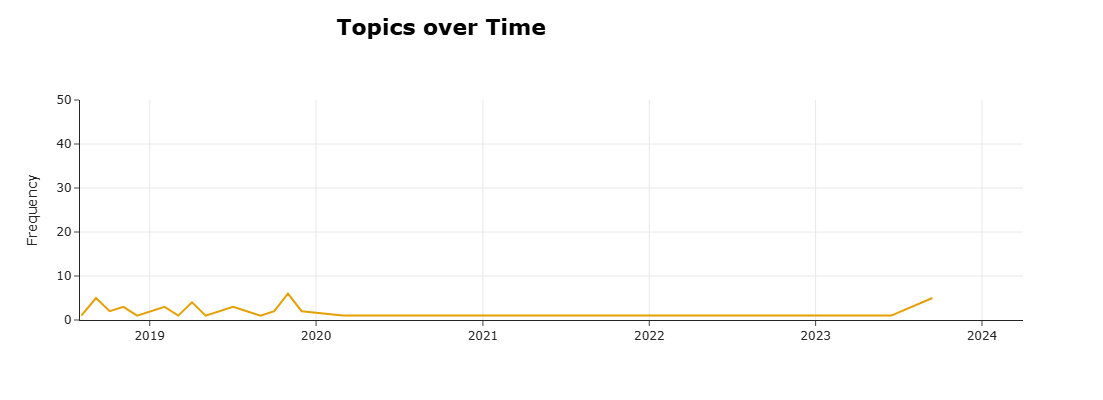

In [298]:
fig = topic_model.visualize_topics_over_time(
    df1_topics_over_time,
    topics=[7],
    height=400,
    width=600
)
fig.update_yaxes(range=[0, 50])  
fig.update_xaxes(range=["2018-08-01", "2024-03-31"])
fig.show()

# topic_model.visualize_topics_over_time(df1_topics_over_time, topics=[7], height=400, width=600)

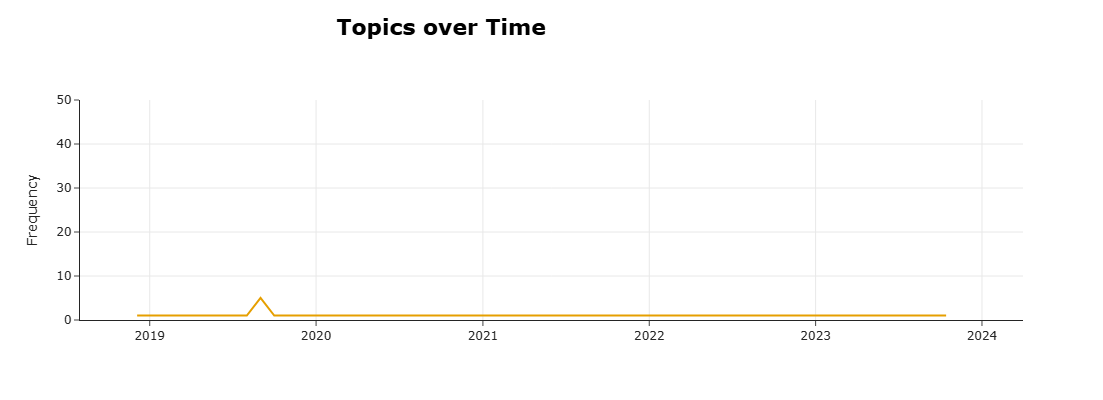

In [300]:
fig = topic_model.visualize_topics_over_time(
    df1_topics_over_time,
    topics=[8],
    height=400,
    width=600
)
fig.update_yaxes(range=[0, 50])  
fig.update_xaxes(range=["2018-08-01", "2024-03-31"])
fig.show()

# topic_model.visualize_topics_over_time(df1_topics_over_time, topics=[8], height=400, width=600)

**Terms per Topic (Matplotlib Manual)**  
0. Generic (outliers)
1. Baggage Handling, Refunds
2. Food & Beverage (Meals)
3. Children Related Accessibility
4. Seat Positions and Modes
5. Premium Economy's Value
6. Entertainment System
7. Toilet Cleanliness
8. Temperature Complaints

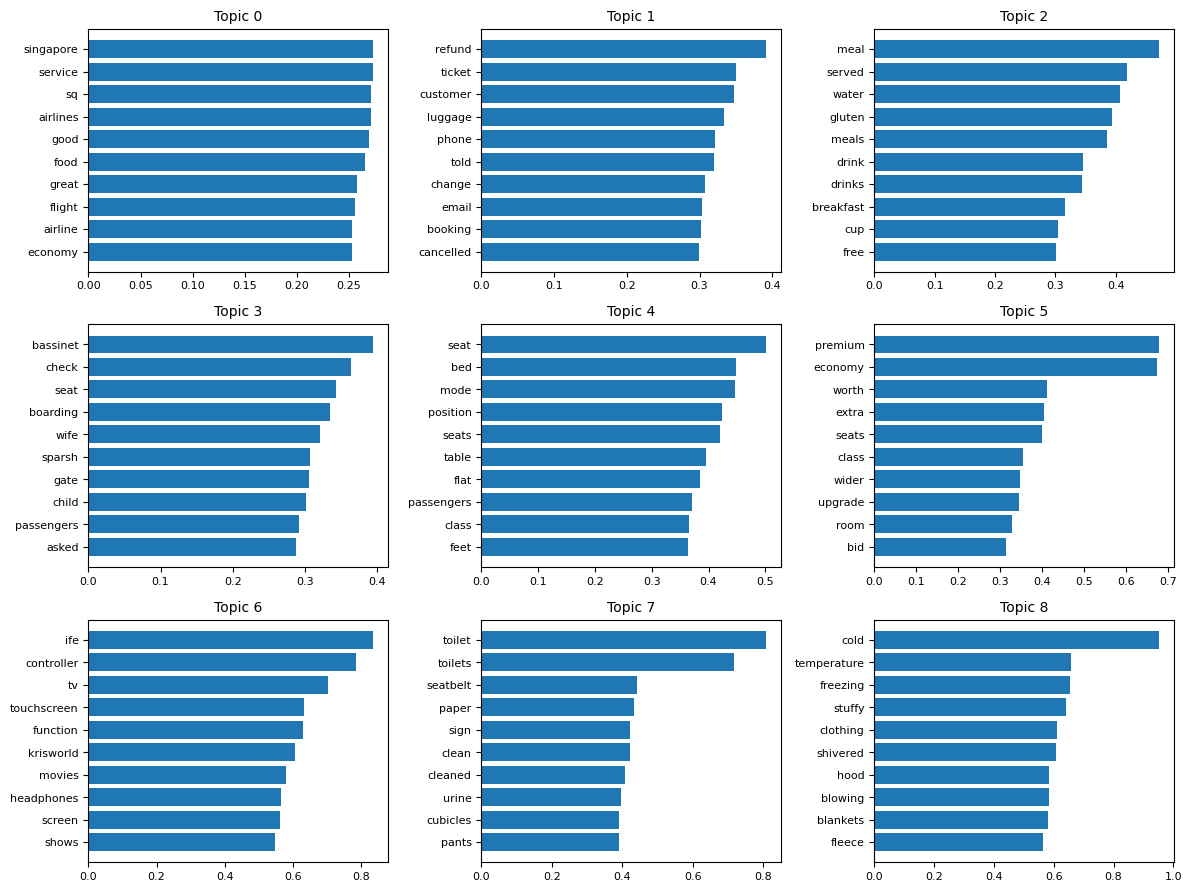

In [162]:
#Visualise topics' top N words
info_output = topic_model.get_topic_info()
unique_topics = [t for t in info_output.Topic if t != -1]

output_cols = 3
output_rows = math.ceil(len(unique_topics) / output_cols)
fig, axes = plt.subplots(output_rows, output_cols, figsize=(output_cols * 4, output_rows * 3))
axes = axes.flatten()

for ax, tid in zip(axes, unique_topics):
    top_words = topic_model.get_topic(tid)[:10]
    words, scores = zip(*top_words)
    
    ax.barh(words, scores)
    ax.set_title(f"Topic {tid}", fontsize=10)
    ax.invert_yaxis()  #
    ax.tick_params(axis='both', labelsize=8)

for ax in axes[len(topics):]:
    ax.axis('off')

plt.tight_layout(pad=1.0)
plt.show()

## Save BERTopic Model

In [117]:
topic_model.save("bertopic_model_mtd1_20250626")

2025-06-26 13:01:00,094 - BERTopic - WARNING: When you use `pickle` to save/load a BERTopic model,please make sure that the environments in which you saveand load the model are **exactly** the same. The version of BERTopic,its dependencies, and python need to remain the same.


## Test that Saved Model Can Load

Load from saved file

In [130]:
loaded_topic_model = BERTopic.load("bertopic_model_mtd1_20250626")

Test by making inference on same `docs_bert`

In [135]:
topics_loadtest, probs_loadtest = loaded_topic_model.transform(docs_bert)

Check that results same

In [137]:
pd.set_option('display.max_colwidth', None)  
topic_info_loadtest = loaded_topic_model.get_topic_info()
print(topic_info_loadtest)

# -1 outliers

   Topic  Count                                Name  \
0     -1   5948       -1_flight_food_singapore_good   
1      0   4385     0_singapore_service_sq_airlines   
2      1    950    1_refund_ticket_customer_luggage   
3      2    315          2_meal_served_water_gluten   
4      3    215      3_bassinet_check_seat_boarding   
5      4    174            4_seat_bed_mode_position   
6      5    165       5_premium_economy_worth_extra   
7      6     60     6_ife_controller_tv_touchscreen   
8      7     54     7_toilet_toilets_seatbelt_paper   
9      8     15  8_cold_temperature_freezing_stuffy   

                                                                               Representation  \
0                [flight, food, singapore, good, seats, service, airlines, seat, staff, time]   
1             [singapore, service, sq, airlines, good, food, great, flight, airline, economy]   
2         [refund, ticket, customer, luggage, phone, told, change, email, booking, cancelled]   
3     

Intertopic distance map varies a little

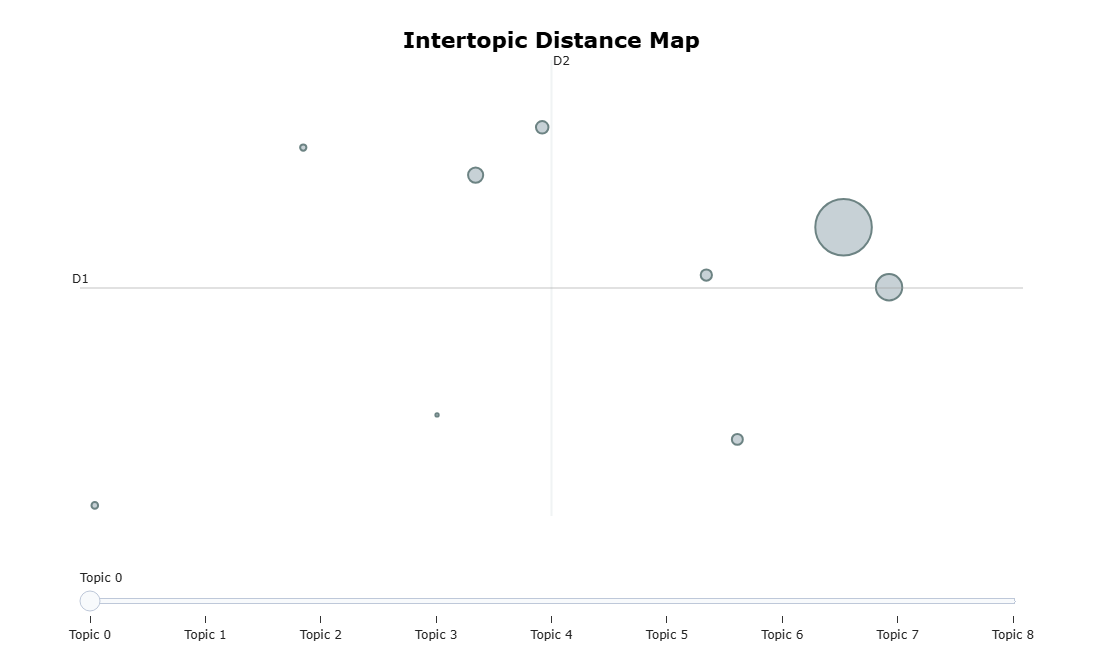

In [139]:
# Intertopic distance map
loaded_topic_model.visualize_topics()

## Pipeline - Sentiment Analysis and Topic Modelling

In [252]:
# Load output from sentiment analysis
base_dir = r"C:\Users\TYY\Desktop\MITB Modules\CS610 AML\Group Project\V2"
stage1_df = pd.read_csv(f"{base_dir}/sentiment_output.csv")

# Convert published_date to correct format
stage1_df["published_date"] = pd.to_datetime(stage1_df["published_date"], utc=True)

In [254]:
stage1_df.head()

,published_date,published_platform,rating,type,text,title,helpful_votes,year,review_length_raw,length_category,Sentiment,sentiment_id,FT_distilbert_pred
0,2023-03-18 08:19:16+00:00,Desktop,5,review,"Flew BKK to Sing and Sing to Perth. Food on both legs was adequate, champagne before take off and nice wines during the flight. More than enough leg room and privacy if needed. What made the legs special was the outstanding service, nothing was too much trouble. All staff I encountered were lovely, but must point out Chia from BKK to Sing and Kat from Sing to Perth; better than I've ever come across.",Faultless,0,2023,74,50-100,Positive,2,2
1,2019-11-06 01:16:30+00:00,Mobile,5,review,Well catered for with gluten free. Comfortable and plenty of space. First leg last row of premium economy so you don't have to worry about people behind. Second leg paid for front of premium economy. Huge space so well worth the money.,Mrs Barb,3,2019,42,20-50,Positive,2,2
2,2019-05-09 22:51:07+00:00,Desktop,5,review,"Check in & boarding was good. but unfortunately you can't choose your seat until 48hours before flight day.\nI ask special treatment for my baggage (food and souvenir for my japanese relation). 1 of chips was broke, I am not sure when and how but it still ok.\n\nentertainment absolutely good\nI got front seat of Economic class and the leg space soooo spaces. but I don't have leg compartment for keep my bag.\n\nthe food is so so, I asked muslim meals",my 1st time flight with 5stars airlines,0,2019,83,50-100,Positive,2,2
3,2019-08-30 08:45:55+00:00,Mobile,5,review,"Staff were super friendly, always on the go. Buzz for an attendant and they are there. No request is too difficult. Onboard entertainment is awesome, something for everyone. Drinks and snacks are served all night, without even having to call for an attendant. Nice airline and always make a point of using them when flying to Asia. An all round great flying experience!",Topped Up,1,2019,63,50-100,Positive,2,2
4,2019-07-17 02:23:56+00:00,Desktop,4,review,"What a surprise - a brand new plane. Seat was so comfortable, Entertainment good. Food was excellent with wine. Flight not full, service very good. \n\nKeep up the good work Singapore Airlines!!",Return flight from Bangkok 16th July 2019,2,2019,32,20-50,Positive,2,2


In [303]:
stage1_df = stage1_df.reset_index().rename(columns={'index': 'review_id'})

In [305]:
# Same text processing

# Add a word_count column so that I can filter later
stage1_df["word_count"] = stage1_df["text"].astype(str).str.split().str.len() # split string into word arrays and count num words

In [307]:
# Filter reviews > 200 words
stage1_df_long_reviews = stage1_df[stage1_df["word_count"] > 200]

# Method 1: By paragraphs
stage1_df_long_reviews['chunks'] = stage1_df_long_reviews['text'].apply(split_into_paragraphs)

In [311]:
# Flatten to a DataFrame of chunks
stage1_df_chunked_rows = []
for _, row in stage1_df_long_reviews.iterrows():
    for chunk in row['chunks']:
        stage1_df_chunked_rows.append({
            'review_id': row['review_id'], 
            'published_date': row['published_date'],
            'sentiment_id': row['sentiment_id'],
            'FT_distilbert_pred': row['FT_distilbert_pred'],
            'text': chunk
        })
stage1_df_chunks = pd.DataFrame(stage1_df_chunked_rows)

In [313]:
stage1_df_chunks.head()

,review_id,published_date,sentiment_id,FT_distilbert_pred,text
0,34,2019-05-08 10:20:59+00:00,1,1,"For long haul flights (especially going to Europe), my husband and I usually fly with Qatar Airways but this year because QR""s rates were higher than expected, we explored other airlines. Though other airlines like Saudia and Etihad were substantially lower than QR, SQ and EK, we decided to go with Singapore Airlines (SQ) because we previously experienced good service over all. Unfortunately, not for the SG-ZRH leg of our trip."
1,34,2019-05-08 10:20:59+00:00,1,1,"We were seated near the galley and we found out that wasn't a good place to be assigned. We were always served last and by the time the attendants reach us, there were no more choices of food. Also, they always rush past you in and out, hence, if you have a request you have to wait a while to be served or noticed."
2,34,2019-05-08 10:20:59+00:00,1,1,"Also, for some reason, SQ provides amenity kits only when you ask to be given one when the attendants with big plastic carrier pass by. If you're not paying attention or is asleep, you won't be given one."
3,34,2019-05-08 10:20:59+00:00,1,1,Disappointing because our previous experiences with SQ were good. The premium cost we paid to fly with them was not worth it.
4,50,2019-09-10 06:10:19+00:00,1,0,"We flew back from Singapore on a night flight. We were in premium economy and were expecting a good quality plane, however the plane was horrible. The aisles were very narrow, which made it very difficult to move around to the toilet. The seats did not recline at all (3 of our 4 seats didn't recline). When we pointed this out to the air stewardess she tried to push it back by putting all her body weight on it and the person behind pulled it and it moved about 1 inch, and then she gave up and said it's quite tricky. The handset for the TV was broken and my son's laptray was broken. It made us wonder what else on the plane was broken. There were only 4 toilets for everyone in economy and premium economy to use. At one point we had to wait 20 minutes to use a toilet, which for someone with medical issues is unacceptable. (& Made me very distressed) Some of the flight staff were very polite, however others seemed brusque and irritable. We were looking forward to the flight as the plane on the way to Singapore felt luxurious, but this plane was"


In [317]:
stage1_df_short_reviews = stage1_df[(stage1_df["word_count"] >= 20) & (stage1_df["word_count"] <= 200)][['review_id', 'published_date', 'sentiment_id', 'FT_distilbert_pred', 'text']]

In [319]:
# Combine back short reviews
stage1_df_final = pd.concat([stage1_df_short_reviews, stage1_df_chunks], ignore_index=True)

In [323]:
# Prepare text into list format expected by BERTopic
stage1_df_final_docs_bert = stage1_df_final["text"].tolist()

Use model to infer topics

In [325]:
topics_stage1_df, probs_stage1_df = topic_model.transform(stage1_df_final_docs_bert)

In [ ]:
# # Alternative: Load model again
# loaded_topic_model = BERTopic.load("bertopic_model_mtd1_20250626")
# topics_stage1_df, probs_stage1_df = loaded_topic_model.transform(stage1_df_final_docs_bert)

Plot Sentiment Distribution by Topic

In [334]:
# Make a copy of the input dataframe and enrich with results
stage1_df_final_wresults = stage1_df_final.copy()
stage1_df_final_wresults['topic'] = topics_stage1_df
stage1_df_final_wresults.head()

,review_id,published_date,sentiment_id,FT_distilbert_pred,text,topic
0,0,2023-03-18 08:19:16+00:00,2,2,"Flew BKK to Sing and Sing to Perth. Food on both legs was adequate, champagne before take off and nice wines during the flight. More than enough leg room and privacy if needed. What made the legs special was the outstanding service, nothing was too much trouble. All staff I encountered were lovely, but must point out Chia from BKK to Sing and Kat from Sing to Perth; better than I've ever come across.",-1
1,1,2019-11-06 01:16:30+00:00,2,2,Well catered for with gluten free. Comfortable and plenty of space. First leg last row of premium economy so you don't have to worry about people behind. Second leg paid for front of premium economy. Huge space so well worth the money.,-1
2,2,2019-05-09 22:51:07+00:00,2,2,"Check in & boarding was good. but unfortunately you can't choose your seat until 48hours before flight day.\nI ask special treatment for my baggage (food and souvenir for my japanese relation). 1 of chips was broke, I am not sure when and how but it still ok.\n\nentertainment absolutely good\nI got front seat of Economic class and the leg space soooo spaces. but I don't have leg compartment for keep my bag.\n\nthe food is so so, I asked muslim meals",-1
3,3,2019-08-30 08:45:55+00:00,2,2,"Staff were super friendly, always on the go. Buzz for an attendant and they are there. No request is too difficult. Onboard entertainment is awesome, something for everyone. Drinks and snacks are served all night, without even having to call for an attendant. Nice airline and always make a point of using them when flying to Asia. An all round great flying experience!",-1
4,4,2019-07-17 02:23:56+00:00,2,2,"What a surprise - a brand new plane. Seat was so comfortable, Entertainment good. Food was excellent with wine. Flight not full, service very good. \n\nKeep up the good work Singapore Airlines!!",-1


In [369]:
stage1_df_final_wresults.to_csv('bertopic_pipeline_results.csv')

In [336]:
stage1_df_final_wo_outlier = stage1_df_final_wresults[stage1_df_final_wresults["topic"] != -1].copy()

In [340]:
sentiment_counts = pd.crosstab(stage1_df_final_wo_outlier["topic"], stage1_df_final_wo_outlier["FT_distilbert_pred"])
sentiment_counts

FT_distilbert_pred,0,1,2
topic,,,
0,47,35,270
1,73,4,9
2,11,7,8
3,9,2,7
4,1,4,10
5,1,2,4
6,0,0,4
7,2,1,5


In [342]:
sentiment_map = {0: "Negative", 1: "Neutral", 2: "Positive"}
sentiment_counts.columns = sentiment_counts.columns.map(sentiment_map)

In [346]:
sentiment_pct = sentiment_counts.div(sentiment_counts.sum(axis=1), axis=0) * 100

In [348]:
# Ensure consistent column order
for c in ["Negative", "Neutral", "Positive"]:
    if c not in sentiment_pct.columns:
        sentiment_pct[c] = 0
sentiment_pct = sentiment_pct[["Negative", "Neutral", "Positive"]]

In [356]:
sentiment_pct

FT_distilbert_pred,Negative,Neutral,Positive
topic,,,
0,13.352273,9.943182,76.704545
1,84.883721,4.651163,10.465116
2,42.307692,26.923077,30.769231
3,50.000000,11.111111,38.888889
4,6.666667,26.666667,66.666667
5,14.285714,28.571429,57.142857
6,0.000000,0.000000,100.000000
7,25.000000,12.500000,62.500000


In [354]:
topic_map = {
    -1: "Outliers",
    0: "Good service",
    1: "Baggage Handling, Refunds",
    2: "Food & Beverage (Meals)",
    3: "Children Related Accessibility",
    4: "Seat Positions and Modes",
    5: "Premium Economy Value",
    6: "Inflight Entertainment System",
    7: "Toilet Cleanliness",
    8: "Temperature Complaints"
}

In [358]:
# Replace index with topic names
sentiment_pct.index = [
    f"{topic_idx}: {topic_map.get(topic_idx, 'Unknown')}" for topic_idx in sentiment_pct.index
]

In [360]:
sentiment_pct

FT_distilbert_pred,Negative,Neutral,Positive
0: Good service,13.352273,9.943182,76.704545
"1: Baggage Handling, Refunds",84.883721,4.651163,10.465116
2: Food & Beverage (Meals),42.307692,26.923077,30.769231
3: Children Related Accessibility,50.000000,11.111111,38.888889
4: Seat Positions and Modes,6.666667,26.666667,66.666667
5: Premium Economy Value,14.285714,28.571429,57.142857
6: Inflight Entertainment System,0.000000,0.000000,100.000000
7: Toilet Cleanliness,25.000000,12.500000,62.500000


In [362]:
sentiment_pct = sentiment_pct.sort_values("Positive", ascending=False)
sentiment_pct

FT_distilbert_pred,Negative,Neutral,Positive
6: Inflight Entertainment System,0.000000,0.000000,100.000000
0: Good service,13.352273,9.943182,76.704545
4: Seat Positions and Modes,6.666667,26.666667,66.666667
7: Toilet Cleanliness,25.000000,12.500000,62.500000
5: Premium Economy Value,14.285714,28.571429,57.142857
3: Children Related Accessibility,50.000000,11.111111,38.888889
2: Food & Beverage (Meals),42.307692,26.923077,30.769231
"1: Baggage Handling, Refunds",84.883721,4.651163,10.465116


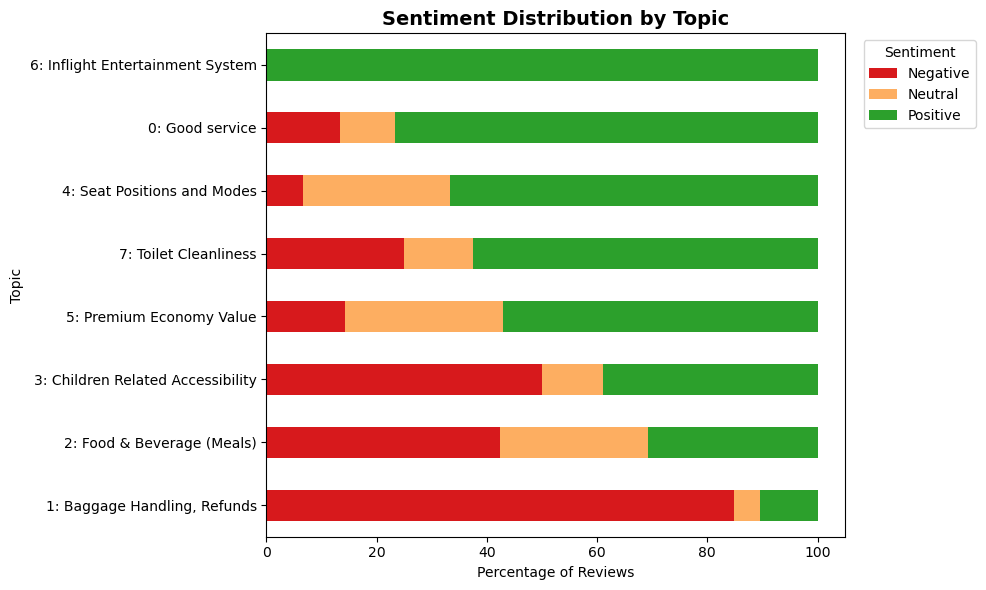

In [364]:
fig, ax = plt.subplots(figsize=(10, 6))
sentiment_pct.plot(
    kind="barh",
    stacked=True,
    ax=ax,
    color=["#d7191c", "#fdae61", "#2ca02c"]
)
ax.invert_yaxis()
ax.set_xlabel("Percentage of Reviews")
ax.set_ylabel("Topic")
ax.set_title("Sentiment Distribution by Topic", fontweight="bold", fontsize=14)
ax.legend(title="Sentiment", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.show()